In [1]:
import numpy as np
import itertools
import pandas as pd

from sklearn.isotonic import IsotonicRegression
from sklearn.calibration import calibration_curve, _SigmoidCalibration
from sklearn.metrics import brier_score_loss, log_loss
from scipy.special import expit

from ampligraph.datasets import load_wordnet11
from ampligraph.latent_features.models import TransE, ComplEx

In [2]:
%env CUDA_VISIBLE_DEVICES=0

env: CUDA_VISIBLE_DEVICES=0


In [3]:
X_train = (pd.read_csv("TransC/data/YAGO39K/Train/triple2id.txt", sep=' ', skiprows=1, names=['s', 'o', 'p'])
           [['s', 'p', 'o']]
           .reindex()
           .values)

In [4]:
ent = np.unique(np.concatenate((X_train[:, 0], X_train[:, 2])))

In [5]:
X_valid_pos = (pd.read_csv("TransC/data/YAGO39K/Valid/triple2id_positive.txt", sep=' ', skiprows=1, names=['s', 'o', 'p'])
               [['s', 'p', 'o']]
               .reindex()
               .query("s in @ent and o in @ent")
               .values)

X_valid_neg = (pd.read_csv("TransC/data/YAGO39K/Valid/triple2id_negative.txt", sep=' ', skiprows=1, names=['s', 'o', 'p'])
               [['s', 'p', 'o']]
               .reindex()
               .query("s in @ent and o in @ent")
               .values)

In [6]:
X_test_pos = (pd.read_csv("TransC/data/YAGO39K/Valid/triple2id_positive.txt", sep=' ', skiprows=1, names=['s', 'o', 'p'])
              [['s', 'p', 'o']]
              .reindex()
              .query("s in @ent and o in @ent")
              .values)

X_test_neg = (pd.read_csv("TransC/data/YAGO39K/Valid/triple2id_negative.txt", sep=' ', skiprows=1, names=['s', 'o', 'p'])
              [['s', 'p', 'o']]
              .query("s in @ent and o in @ent")
              .reindex()
              .values)

In [7]:
X = {
    'train': X_train,
    'valid': np.concatenate((X_valid_pos, X_valid_neg)),
    'test': np.concatenate((X_test_pos, X_test_neg)),
    'valid_labels': np.concatenate((np.full(len(X_valid_pos), '1'), np.full(len(X_valid_neg), '-1'))),
    'test_labels': np.concatenate((np.full(len(X_test_pos), '1'), np.full(len(X_test_neg), '-1')))
}

In [ ]:
model = TransE(batches_count=64, seed=0, epochs=1000, k=100, eta=20,
               optimizer='adam', optimizer_params={'lr':0.0001},
               loss='nll', verbose=False)

model.fit(X['train'])

WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.
WARNING - From /home/ptabacof/.conda/envs/tf_gpu/lib/python3.7/site-packages/tensorflow/python/data/ops/dataset_ops.py:429: py_func (from tensorflow.python.ops.script_ops) is deprecated and will be removed in a future version.
Instructions for updating:
tf.py_func is deprecated in TF V2. Instead, use
    tf.py_function, which takes a python function which manipulates tf eager
    tensors instead of numpy arrays. It's easy to convert a tf eager tensor to
    an ndarray (just call tensor.numpy()) but having access to eager tensors
    means `tf.py_function`s can use accelerators such as GPUs as well as
    being differentiable using a gradient tape.
    
WARNING - From /home/ptabacof/.

In [ ]:
import types
from functools import partial
import tensorflow as tf
from sklearn.utils import check_random_state
from tqdm import tqdm
from ampligraph.datasets import AmpligraphDatasetAdapter, NumpyDatasetAdapter
from ampligraph.evaluation import generate_corruptions_for_fit, to_idx, generate_corruptions_for_eval, \
    hits_at_n_score, mrr_score


def generate_corruptions(self, X_pos, batches_count, epochs):
    try:
        tf.reset_default_graph()
        self.rnd = check_random_state(self.seed)
        tf.random.set_random_seed(self.seed)

        self._load_model_from_trained_params()

        dataset_handle = NumpyDatasetAdapter()
        dataset_handle.use_mappings(self.rel_to_idx, self.ent_to_idx)

        dataset_handle.set_data(X_pos, "pos")

        batch_size_pos = int(np.ceil(dataset_handle.get_size("pos") / batches_count))

        gen_fn = partial(dataset_handle.get_next_train_batch, batch_size=batch_size_pos, dataset_type="pos")
        dataset = tf.data.Dataset.from_generator(gen_fn,
                                                 output_types=tf.int32,
                                                 output_shapes=(None, 3))
        dataset = dataset.repeat().prefetch(1)
        dataset_iter = tf.data.make_one_shot_iterator(dataset)

        x_pos_tf = dataset_iter.get_next()

        e_s, e_p, e_o = self._lookup_embeddings(x_pos_tf)
        scores_pos = self._fn(e_s, e_p, e_o)

        x_neg_tf = generate_corruptions_for_fit(x_pos_tf,
                                                entities_list=None,
                                                eta=1,
                                                corrupt_side='s+o',
                                                entities_size=0,
                                                rnd=self.seed)

        e_s_neg, e_p_neg, e_o_neg = self._lookup_embeddings(x_neg_tf)
        scores = self._fn(e_s_neg, e_p_neg, e_o_neg)

        epoch_iterator_with_progress = tqdm(range(1, epochs + 1), disable=(not self.verbose), unit='epoch')

        scores_list = []
        with tf.Session(config=self.tf_config) as sess:
            sess.run(tf.global_variables_initializer())
            for _ in epoch_iterator_with_progress:
                losses = []
                for batch in range(batches_count):
                    scores_list.append(sess.run(scores))

        dataset_handle.cleanup()
        return np.concatenate(scores_list)
    
    except Exception as e:
        dataset_handle.cleanup()
        raise e

In [ ]:
def pos_iso(cal_model, pos_scores, neg_scores, positive_base_rate):
    weigths_pos = len(neg_scores) / len(pos_scores)
    weights_neg = (1.0 - positive_base_rate) / positive_base_rate
    weights = np.concatenate((np.full(pos_scores.shape, weigths_pos),
                              np.full(neg_scores.shape, weights_neg))).astype(float)
    target =  np.concatenate((np.ones(pos_scores.shape), np.zeros(neg_scores.shape))).astype(float)
    x = np.concatenate((pos_scores, neg_scores)).astype(float)
    
    cal_model.fit(x, target, sample_weight=weights)
    return cal_model

In [ ]:
scores = model.predict(X['test'])

model.calibrate(X_valid_pos, batches_count=10, epochs=100, positive_base_rate=0.5)
probas1 = model.predict_proba(X['test'])

model.calibrate(X_valid_pos, X_valid_neg, batches_count=10, epochs=100)
probas2 = model.predict_proba(X['test'])

In [ ]:
val_scores = model.predict(X['valid'])

In [ ]:
ir = IsotonicRegression(out_of_bounds='clip')
ir.fit(np.squeeze(val_scores).astype(float), (X['valid_labels'] == "1").astype(float))
probas3 = ir.predict(np.squeeze(scores).astype(float))

In [ ]:
sc = _SigmoidCalibration()
sc.fit(np.squeeze(val_scores).astype(float), (X['valid_labels'] == "1").astype(float))
probas4 = sc.predict(np.squeeze(scores).astype(float))

In [ ]:
model.generate_corruptions = types.MethodType(generate_corruptions, model)
corruptions = model.generate_corruptions(X_valid_pos, batches_count=10, epochs=1000)
val_pos_scores = np.squeeze(model.predict(X_valid_pos))
iso_pos = pos_iso(IsotonicRegression(out_of_bounds='clip'), val_pos_scores, corruptions, positive_base_rate=0.5)
probas5 = iso_pos.predict(np.squeeze(scores).astype(float))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

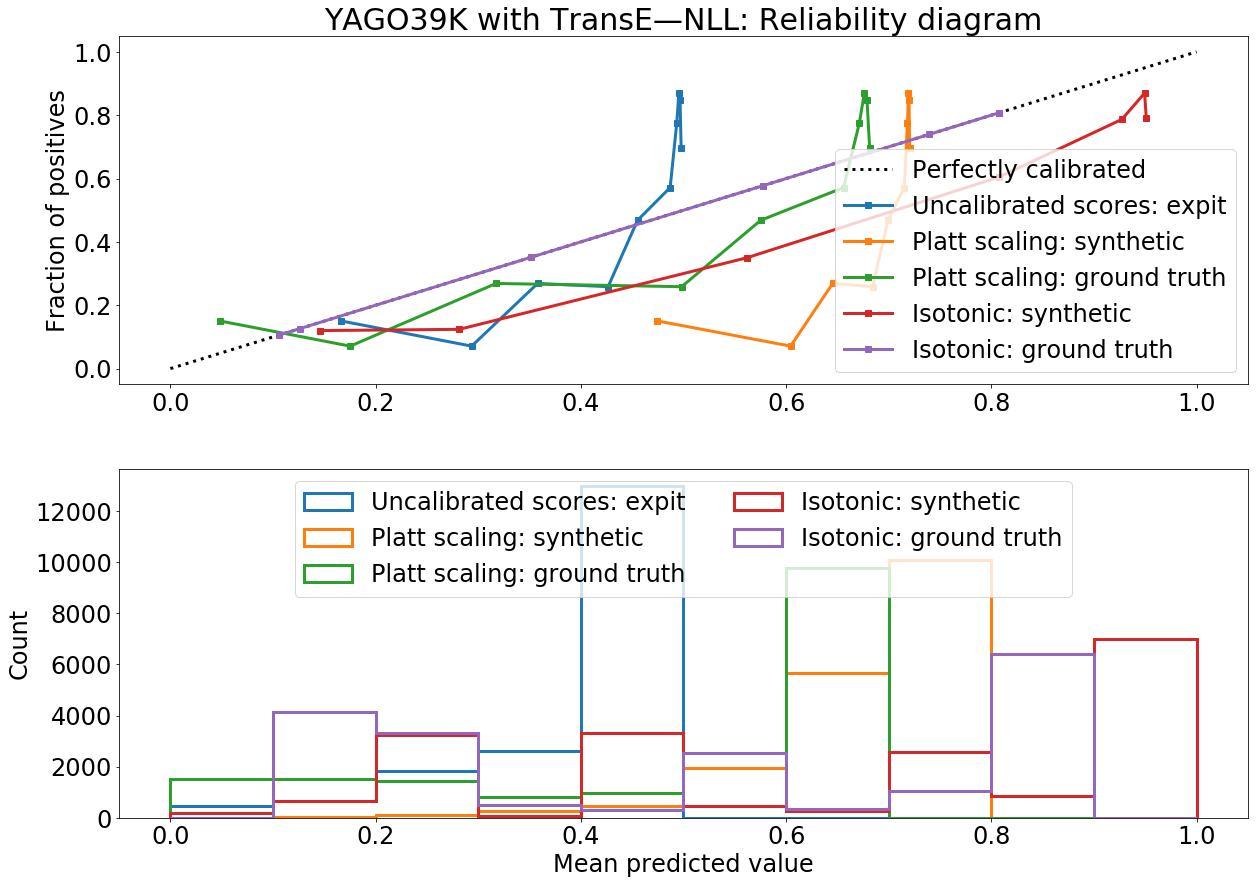

In [18]:
plt.rcParams.update({'font.size': 24, 'axes.titlesize': 30})

fig = plt.figure(figsize=(18, 18))
ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=1)
ax2 = plt.subplot2grid((3, 1), (1, 0))

ax1.plot([0, 1], [0, 1], "k:", lw=3, label="Perfectly calibrated")
#ax1.grid()

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
                                                                expit(scores), n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Uncalibrated scores: expit")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
                                                                probas1, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Platt scaling: synthetic")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
                                                                probas2, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Platt scaling: ground truth")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
                                                                probas5, n_bins=8, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Isotonic: synthetic")

fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
                                                                probas3, n_bins=10, strategy="quantile")
ax1.plot(mean_predicted_value, fraction_of_positives, "s-", lw=3, label="Isotonic: ground truth")

# fraction_of_positives, mean_predicted_value = calibration_curve(X['test_labels'] == "1", 
#                                                                 probas4, n_bins=10, strategy="quantile")
# ax1.plot(mean_predicted_value, fraction_of_positives, "s-", label="calibration_pos_neg_sc")


ax2.hist(expit(scores), range=(0, 1), bins=10,
         histtype="step", lw=3, label="Uncalibrated scores: expit")

ax2.hist(probas1, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Platt scaling: synthetic")

ax2.hist(probas2, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Platt scaling: ground truth")

ax2.hist(probas5, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Isotonic: synthetic")

ax2.hist(probas3, range=(0, 1), bins=10,
         histtype="step", lw=3, label="Isotonic: ground truth")

# ax2.hist(probas4, range=(0, 1), bins=10,
#          histtype="step", lw=2, label="calibration_pos_neg_sc")

ax1.set_ylabel("Fraction of positives")
ax1.set_ylim([-0.05, 1.05])
ax1.legend(loc="lower right")
ax1.set_title('YAGO39K with TransE—NLL: Reliability diagram')

ax2.set_xlabel("Mean predicted value")
ax2.set_ylabel("Count")
ax2.legend(loc="upper center", ncol=2)


plt.tight_layout()